# An introduction to Deep Generative Models:
## Masked AutoEncoder for Density Estimation in Pytorch
**Sources:**
- Adaptation from [NADE](https://github.com/EugenHotaj/pytorch-generative/blob/master/pytorch_generative/models/autoregressive/nade.py)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import os
import json
import matplotlib.pyplot as plt

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LinearMasked(nn.Linear):
    """
    Class implementing nn.Linear with mask
    """

    def __init__(self, in_features, out_features, bias=True, device = 'mps'):
        super().__init__(in_features, out_features, bias)
        self.mask = None
        self.device = device
        # self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask = torch.from_numpy(mask.astype(np.uint8))
        # self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8)))

    def forward(self, x):
        return F.linear(x.to(device), self.mask.to(device) * self.weight.to(device), self.bias)

class MADE(nn.Module):
    """ MADE model for binary image dataset. """
    def __init__(self, input_dim, use_cuda=True):
        super().__init__()
        self.input_dim = input_dim
        self.device = torch.device('mps') 

        self.net = nn.Sequential(
            LinearMasked(input_dim, input_dim), nn.ReLU(),
            LinearMasked(input_dim, input_dim), nn.ReLU(),
            LinearMasked(input_dim, input_dim)
        )

        self.apply_masks()

    def forward(self, x):
        return self.net(x)

    def set_mask(self, mask):
        self.mask = torch.from_numpy(mask.astype(np.uint8)).to(self.device)
        # self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8)))

    def apply_masks(self):
        # Set order of masks, i.e. who can make which edges
        # Using natural ordering
        order1 = np.arange(self.input_dim)
        order2 = np.arange(self.input_dim)
        order3 = np.arange(self.input_dim)

        # Construct the mask matrices
        masks = []
        m1 = (order1[:, None] <= order2[None,:]).T
        m2 = (order2[:, None] <= order3[None,:]).T
        m3 = (order2[:,None] < order3[None,:]).T
        masks.append(m1)
        masks.append(m2)
        masks.append(m3)

        # Set the masks in all LinearMasked layers
        layers = [l for l in self.net.modules() if isinstance(l, LinearMasked)]

        for l, m in zip(layers, masks):
            l.set_mask(m)

In [4]:
#Dataset parameters
dataset_path = './datasets'
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 256

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=False)
val_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader  = DataLoader(dataset=val_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
def nll_loss(batch, output):
    return F.binary_cross_entropy(torch.sigmoid(output), batch)

H, W = 28, 28
input_dim = H * W
model = MADE(input_dim)
    
epochs = 10
lr = 0.005

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
epochs = 25
save_every = 5
train=True
checkpoint_path = './logs/ar/made/checkpoints'
loss_hist = {'epoch': [], 'train_loss': [], 'val_loss': []}

if train:
    for epoch in range(epochs):
    
        #Training loss
        model.train()
        train_loss = 0.0
        for batch_idx, (batch, _) in enumerate(train_loader):
        
            optimizer.zero_grad()
            # preprocess to binary
            inputs = batch.view(batch.size(0), -1).gt(0.).float().to(device)
            output = model(inputs)
            loss = nll_loss(inputs, output)
            loss.backward()
            optimizer.step()
            # record
            train_loss += loss.item()  
            
        train_loss = train_loss/len(train_loader.dataset)
        loss_hist['train_loss'].append(train_loss)
    
    
        #Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (batch, _) in val_loader:
                # preprocess to binary
                inputs = batch.view(batch.size(0), -1).gt(0.).float().to(device)
                output = model(inputs)
                loss = nll_loss(inputs, output)
                val_loss += loss.item()
    
            val_loss = val_loss/len(val_loader.dataset)
            loss_hist['val_loss'].append(val_loss)
    
        loss_hist['epoch'].append(epoch)
    
        print(f'Epoch: {epoch} - Train loss: {train_loss} - Val loss: {val_loss}')
    
        #scheduler.step()
    
        #Save model 
        if epoch % save_every == 0 or epoch == epochs-1:
            print('Saving model...') 
            path = os.path.join(checkpoint_path, f'made_mnist_epoch_{epoch}.ckpt')
            torch.save(model.state_dict(), path)
            with open('./logs/ar/made/loss.json', 'w') as out_file:
                json.dump(loss_hist, out_file, indent = 6)

else:
    ckpt_path = os.path.join(checkpoint_path, 'made_mnist_epoch_24.ckpt')
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()

Epoch: 0 - Train loss: 0.0009106149303416411 - Val loss: 0.000629798024892807
Saving model...
Epoch: 1 - Train loss: 0.0005483304093281428 - Val loss: 0.0005065262407064438
Epoch: 2 - Train loss: 0.00048025529757142065 - Val loss: 0.00047254047989845276
Epoch: 3 - Train loss: 0.0004534622268130382 - Val loss: 0.00045653168186545373
Epoch: 4 - Train loss: 0.00043794465735554696 - Val loss: 0.0004447474256157875
Epoch: 5 - Train loss: 0.00042788748033344745 - Val loss: 0.00043752764388918877
Saving model...
Epoch: 6 - Train loss: 0.0004205273525168498 - Val loss: 0.0004323145627975464
Epoch: 7 - Train loss: 0.0004155773350348075 - Val loss: 0.0004324221596121788
Epoch: 8 - Train loss: 0.00041015924314657845 - Val loss: 0.00042278709411621096
Epoch: 9 - Train loss: 0.00040628889116148156 - Val loss: 0.00042461633607745173
Epoch: 10 - Train loss: 0.00040319122187793254 - Val loss: 0.00042234934121370316
Saving model...
Epoch: 11 - Train loss: 0.00040059493159254393 - Val loss: 0.0004192645

Text(0.5, 1.0, 'MADE loss')

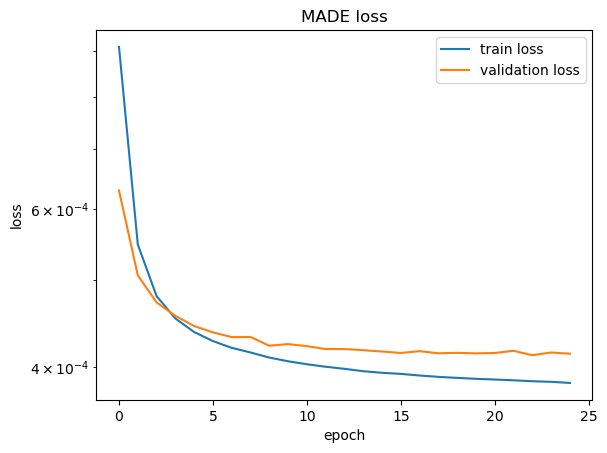

In [10]:
import matplotlib.pyplot as plt
with open('./logs/ar/made/loss.json', 'r') as in_file:
    loss_hist = json.load(in_file)

plt.semilogy(loss_hist['epoch'], loss_hist['train_loss'])
plt.semilogy(loss_hist['epoch'], loss_hist['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss','validation loss'])
plt.title('MADE loss')

### Sampling

In [11]:
# Generate samples
num_samples=16
def gen_samples(num_samples):
    model.eval()
    samples = torch.zeros(size=(num_samples, H * W)).to(device)
    with torch.no_grad():
        for i in range(H * W):
            logits = model(samples)
            probas = torch.sigmoid(logits)
            pixel_i_samples = torch.bernoulli(probas[:, i])
            samples[:, i] = pixel_i_samples
    return samples.reshape(num_samples, H, W).numpy()

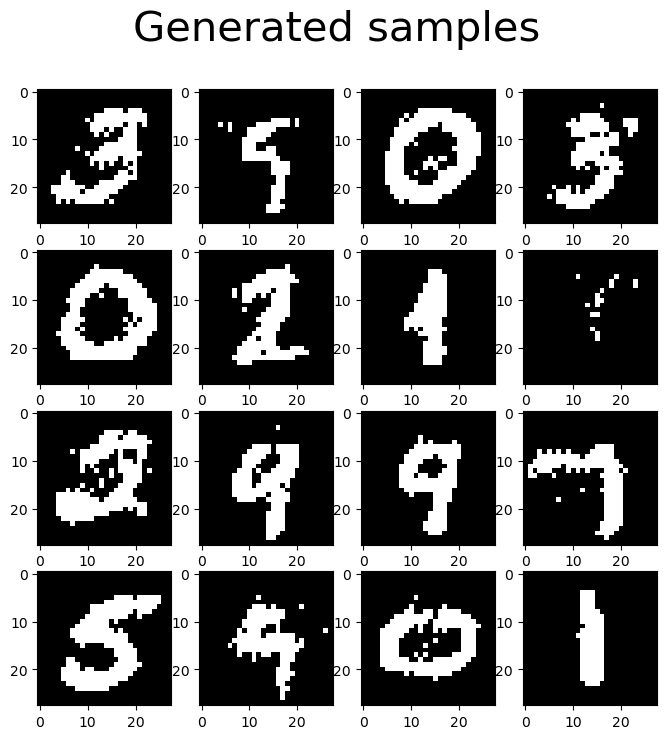

In [13]:
generated = gen_samples(num_samples)
show_images(generated, "Generated samples")